# Separate Notebook for Modelling

### Import Libraries

In [6]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact
from causalimpact.misc import standardize
import matplotlib
import seaborn as sns
import requests as r
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow_probability as tfp
import tensorflow as tf
import datetime
%matplotlib inline
from statsmodels.tsa.stattools import grangercausalitytests
# add some basic matplotlib defaults
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 6)
# set plot size and type to ggplot
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Set up Tensorflow Distributions

In [207]:
tfd = tfp.distributions

### Import Cleaned Dataset

In [195]:
df = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\final_monthly_data.csv', parse_dates=['case_date'], index_col="case_date")

ACF Plot

### Set Up Modelling Vars

In [151]:
MISD_ONLY = 'charges_m'
FEL_ONLY = 'charges_f'
MISD_FEL = 'charges_fm'

In [152]:
MISD_MULTI = ['charges_m','monthly_retail_theft_arrest',  'Value', 'PRCP', 'TAVG']
FEL_MULTI = ['charges_f','monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']
MISD_FEL_MULTI = ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP','TAVG']

In [153]:
UNIVARIATE = [MISD_FEL, FEL_ONLY, MISD_ONLY]
MULTIVARIATE = [MISD_FEL_MULTI, FEL_MULTI,MISD_MULTI,] 

In [154]:
PRE_PERIOD = ['2014-01-01', '2016-11-01']
POST_PERIOD = ['2016-12-01', '2018-12-01']

### Check Whether Monthly Retail Theft Incident's with an Arrest Was Affected by Kim Foxx Policy


In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [131]:
df['year'] = df.reset_index()['case_date'].dt.year #['monthly_retail_theft_arrest'].plot()

<AxesSubplot:xlabel='case_date'>

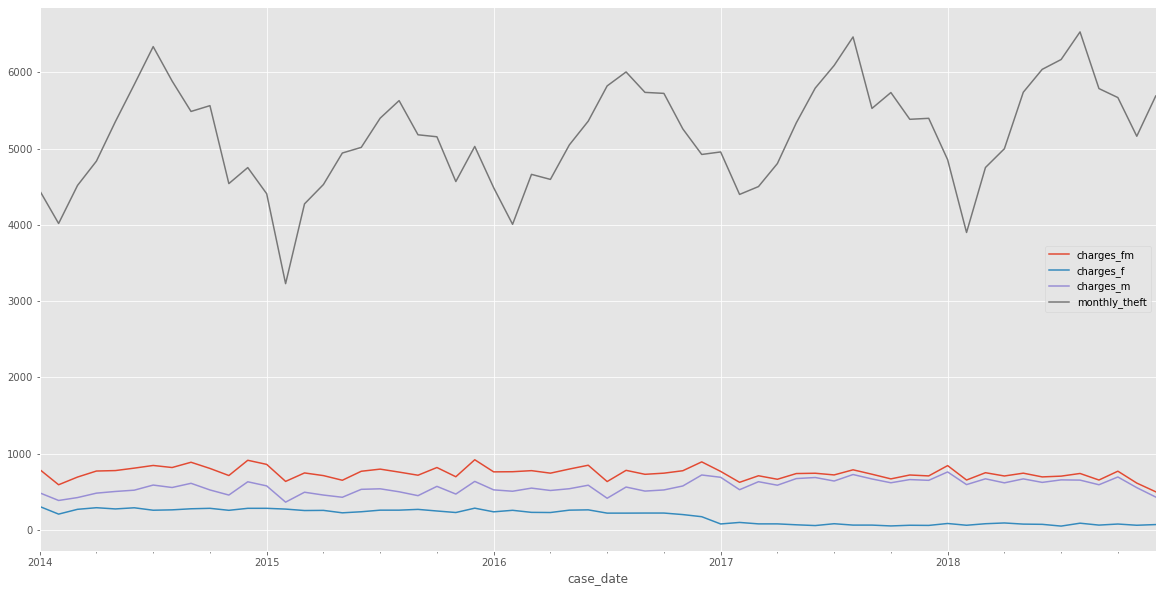

In [145]:
df[['charges_fm', 'charges_f','charges_m','monthly_theft']].plot()

Retail thefts show no large shock after Kim Foxx's change in policy in a seasonal decomposition. Overall thefts were trending upward well before Kim Foxx took office and implemented her policy. We can use overall time series as a covariate.

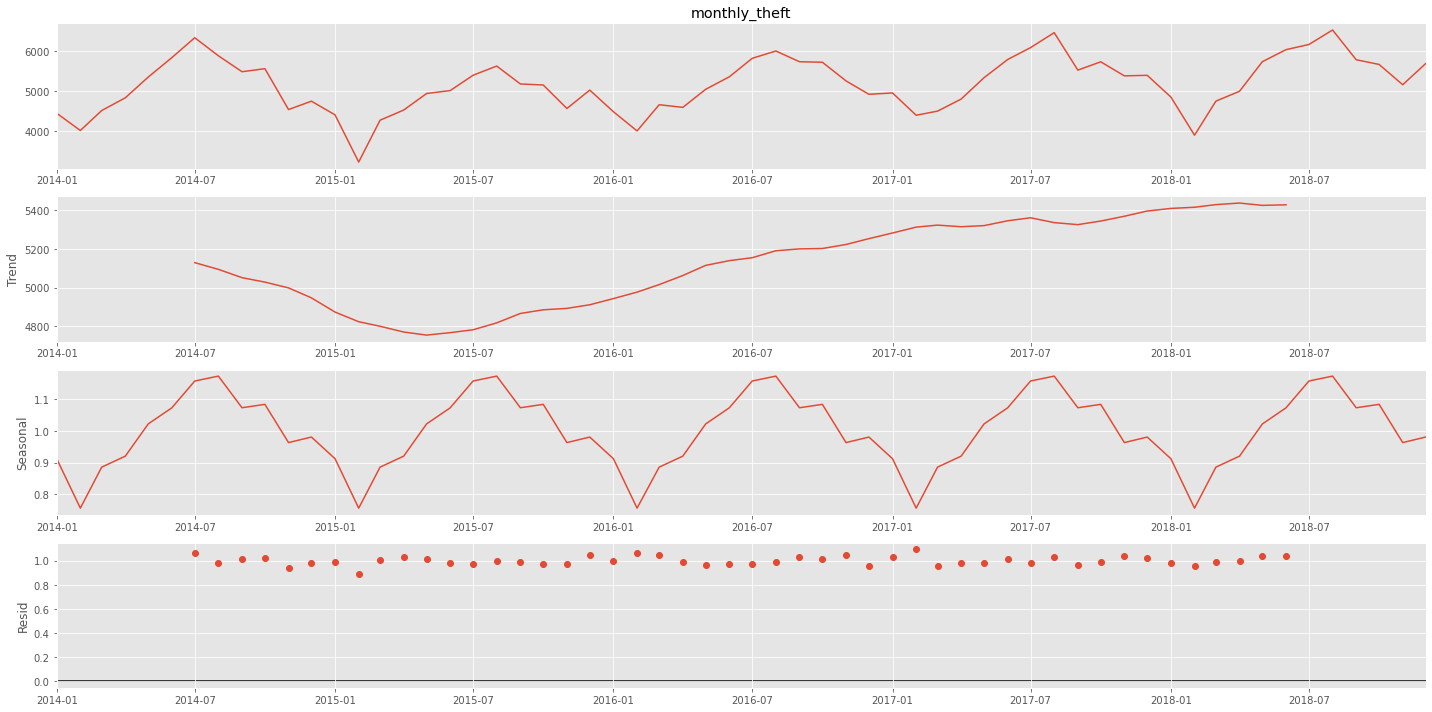

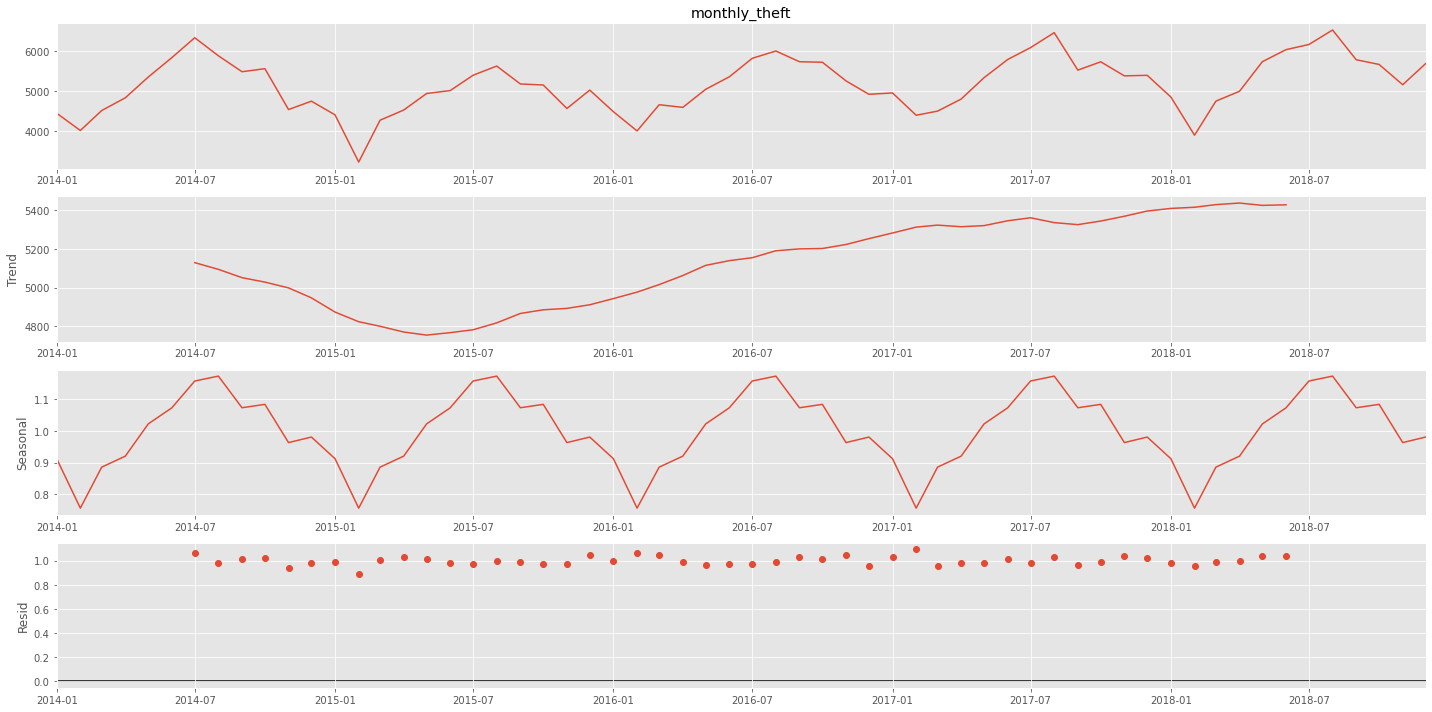

In [146]:
seasonal_decompose(df['monthly_theft'], model="multiplicative").plot()

<AxesSubplot:xlabel='case_date'>

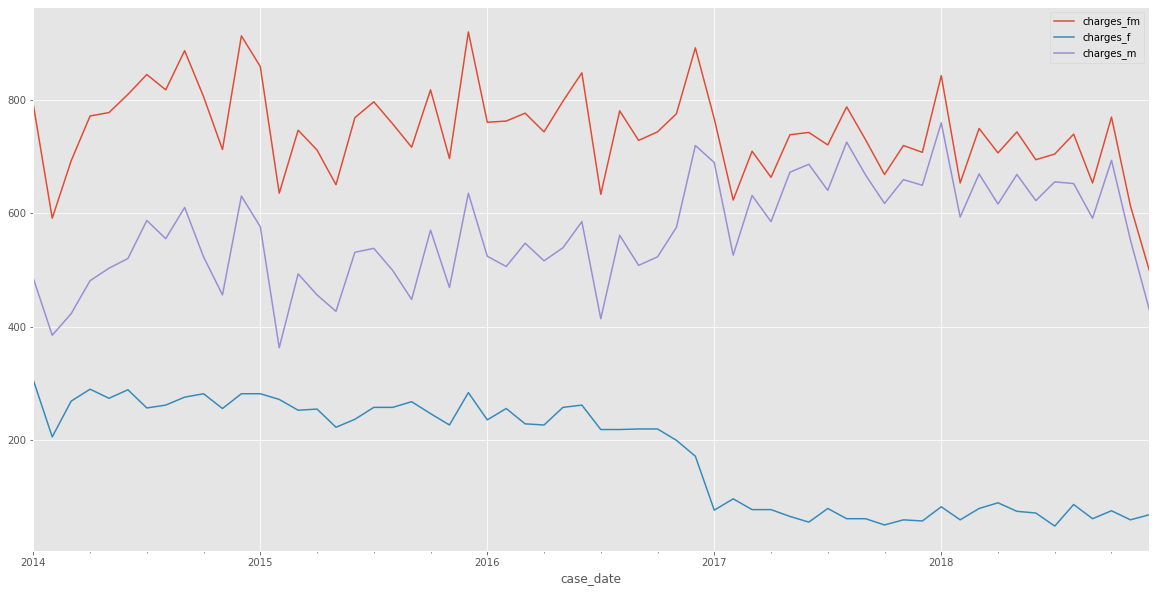

In [113]:
df.reset_index()[['charges_fm', 'charges_f','charges_m','case_date']].groupby('case_date').sum().plot()

### Define Causal Impact Model

In [301]:
def run_causal_impact(dataframe, cols, pre_period, post_period, model=None):
    
    if model == None:
        ci = CausalImpact(dataframe[cols], pre_period=pre_period, post_period=post_period, model_args={'prior_level_sd':0.01, 'fit_method': 'vi'})
    else:
        ci = CausalImpact(dataframe[cols], pre_period=pre_period, post_period=post_period, model_args={'prior_level_sd':0.01,'nseasons':4, 'fit_method': 'vi'}, model=model)
    
    figsize = (20, 6)
    print(f"Summary results for model {cols}:{ci.summary()}")
    print(ci.plot())
    
    return [ci, ci.summary(), ci.summary('report')]

# Run Causal Impact on Felony Thefts

Review original Kim Foxx Effect methods [here](https://projects.chicagoreporter.com/kim-foxx-prosecutions-20191024/#method).

Overview on model args [here](https://stats.stackexchange.com/questions/209426/predictions-from-bsts-model-in-r-are-failing-completely).

Run a univariate model and then one with covariates.

# Run Univariate Models

Summary results for model charges_fm:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    713.04             17826.0
Prediction (s.d.)         766.38 (15.63)     19159.47 (390.7)
95% CI                    [735.7, 796.96]    [18392.43, 19923.96]

Absolute effect (s.d.)    -53.34 (15.63)     -1333.47 (390.7)
95% CI                    [-83.92, -22.66]   [-2097.96, -566.43]

Relative effect (s.d.)    -6.96% (2.04%)     -6.96% (2.04%)
95% CI                    [-10.95%, -2.96%]  [-10.95%, -2.96%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


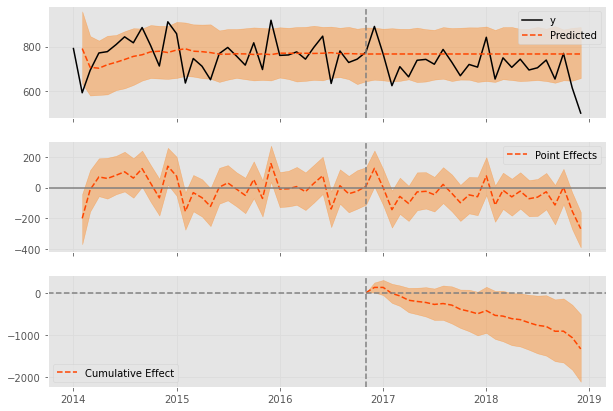

None
Summary results for model charges_f:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    74.4               1860.0
Prediction (s.d.)         252.72 (6.13)      6318.06 (153.23)
95% CI                    [240.4, 264.42]    [6009.94, 6610.61]

Absolute effect (s.d.)    -178.32 (6.13)     -4458.06 (153.23)
95% CI                    [-190.02, -166.0]  [-4750.61, -4149.94]

Relative effect (s.d.)    -70.56% (2.43%)    -70.56% (2.43%)
95% CI                    [-75.19%, -65.68%] [-75.19%, -65.68%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


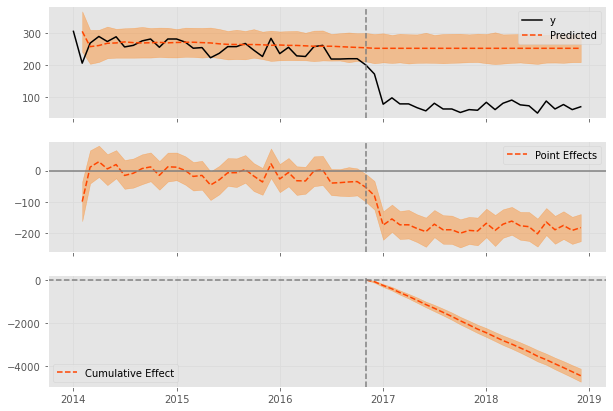

None
Summary results for model charges_m:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    638.64             15966.0
Prediction (s.d.)         513.32 (13.91)     12833.05 (347.75)
95% CI                    [485.27, 539.8]    [12131.86, 13495.04]

Absolute effect (s.d.)    125.32 (13.91)     3132.95 (347.75)
95% CI                    [98.84, 153.37]    [2470.96, 3834.14]

Relative effect (s.d.)    24.41% (2.71%)     24.41% (2.71%)
95% CI                    [19.25%, 29.88%]   [19.25%, 29.88%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


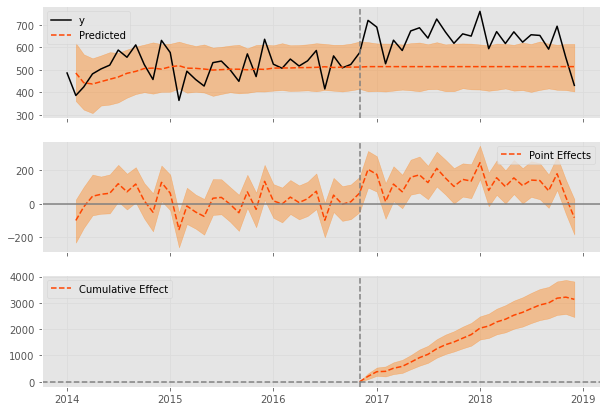

None


In [302]:
uni_all_result, uni_fel_result, uni_misd_result = [run_causal_impact(dataframe=df, cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD) for col in UNIVARIATE]

# Run Multivariate Models

Summary results for model ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    713.04             17826.0
Prediction (s.d.)         755.53 (22.32)     18888.18 (558.09)
95% CI                    [712.9, 800.4]     [17822.38, 20010.05]

Absolute effect (s.d.)    -42.49 (22.32)     -1062.18 (558.09)
95% CI                    [-87.36, 0.14]     [-2184.05, 3.62]

Relative effect (s.d.)    -5.62% (2.95%)     -5.62% (2.95%)
95% CI                    [-11.56%, 0.02%]   [-11.56%, 0.02%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 97.4%

For more details run the command: print(impact.summary('report'))


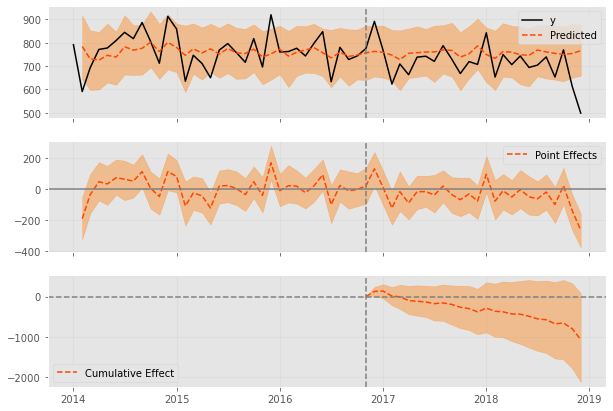

None
Summary results for model ['charges_f', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    74.4               1860.0
Prediction (s.d.)         249.3 (8.41)       6232.55 (210.35)
95% CI                    [229.8, 262.78]    [5744.9, 6569.45]

Absolute effect (s.d.)    -174.9 (8.41)      -4372.55 (210.35)
95% CI                    [-188.38, -155.4]  [-4709.45, -3884.9]

Relative effect (s.d.)    -70.16% (3.37%)    -70.16% (3.37%)
95% CI                    [-75.56%, -62.33%] [-75.56%, -62.33%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


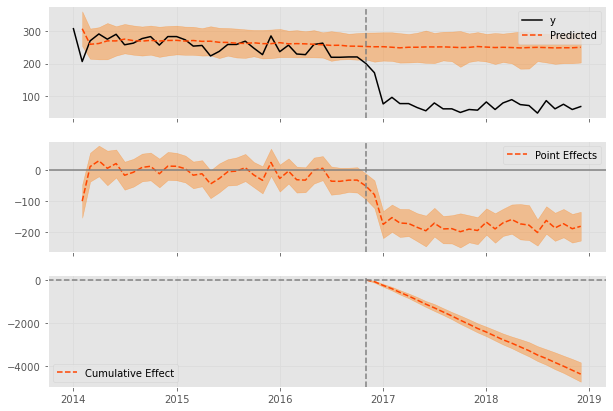

None
Summary results for model ['charges_m', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    638.64             15966.0
Prediction (s.d.)         515.72 (33.38)     12893.03 (834.51)
95% CI                    [466.26, 597.11]   [11656.47, 14927.67]

Absolute effect (s.d.)    122.92 (33.38)     3072.97 (834.51)
95% CI                    [41.53, 172.38]    [1038.33, 4309.53]

Relative effect (s.d.)    23.83% (6.47%)     23.83% (6.47%)
95% CI                    [8.05%, 33.43%]    [8.05%, 33.43%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.6%

For more details run the command: print(impact.summary('report'))


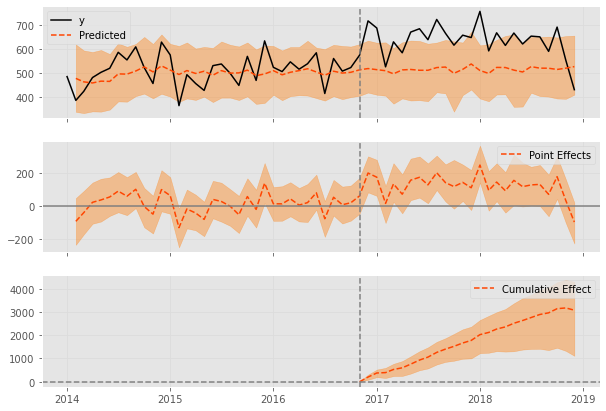

None


In [308]:
multi_all_result, mutli_fel_result, multi_misd_result = [run_causal_impact(dataframe=df, cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD) for col in MULTIVARIATE]

In [293]:
multi_all_result[0].inferences[multi_all_result[0].inferences.index>= '2016-12-01' ]['complete_preds_means']

2016-12-01    793.649292
2017-01-01    765.592407
2017-02-01    746.568909
2017-03-01    722.558350
2017-04-01    789.609436
2017-05-01    763.979919
2017-06-01    754.075195
2017-07-01    738.925415
2017-08-01    796.231873
2017-09-01    767.188293
2017-10-01    743.870911
2017-11-01    733.153442
2017-12-01    803.367310
2018-01-01    760.600769
2018-02-01    740.803040
2018-03-01    736.806702
2018-04-01    789.888062
2018-05-01    759.094910
2018-06-01    746.873901
2018-07-01    739.771545
2018-08-01    790.932800
2018-09-01    760.400818
2018-10-01    746.580994
2018-11-01    732.534607
2018-12-01    793.032471
Freq: MS, Name: complete_preds_means, dtype: float32

In [291]:
multi_all_result[0].data[multi_all_result[0].data.index >= '2016-12-01']['charges_fm']

case_date
2016-12-01    891.0
2017-01-01    766.0
2017-02-01    623.0
2017-03-01    709.0
2017-04-01    663.0
2017-05-01    738.0
2017-06-01    742.0
2017-07-01    720.0
2017-08-01    787.0
2017-09-01    729.0
2017-10-01    668.0
2017-11-01    719.0
2017-12-01    707.0
2018-01-01    842.0
2018-02-01    653.0
2018-03-01    749.0
2018-04-01    706.0
2018-05-01    743.0
2018-06-01    694.0
2018-07-01    704.0
2018-08-01    739.0
2018-09-01    653.0
2018-10-01    769.0
2018-11-01    613.0
2018-12-01    499.0
Name: charges_fm, dtype: float64

### Calculate MAPE to Evaluate Pre-Prediction Fit

[What is MAPE? What is a "good" MAPE Score?](https://stephenallwright.com/good-mape-score/)

- The lower the percentage, the more accurate the model, so 10% is better than 20%
- A perfect MAPE score would be inappropriate for this project we may overfit a time series.
- A good MAPE is arbitray and domain specific, but rule of thumb says < 10 % is very good.

There are no large outliers in the pre-prediction dataset or zero values, as a result MAPE serves as a reliable error metric for this forecasting project.

In [277]:
from sklearn.metrics import mean_absolute_percentage_error

### The Multivariate Model Improves Pre-prediction Fit

The multivariate model provides a slight improvement to the pre-prediction fit. This is especially true for all thefts and all misdemeanor retail thefts.

In [335]:
for offense,model in zip(["all", "felony", "misdemeanor"],[uni_all_result, uni_fel_result, uni_misd_result]):
    
    mape = mean_absolute_percentage_error(model[0].data[model[0].data.index <= '2016-12-01'],\
                                  model[0].inferences[model[0].inferences.index <= '2016-12-01' ]['complete_preds_means'])

    print(f"The univariate model for {offense} retail thefts has a pre-prediction MAPE of {mape}")

The univariate model for all retail thefts has a pre-prediction MAPE of 0.08408731874005963
The univariate model for felony retail thefts has a pre-prediction MAPE of 0.10379056232569323
The univariate model for misdemeanor retail thefts has a pre-prediction MAPE of 0.113357907876611


In [336]:
for offense,model in zip(["all", "felony", "misdemeanor"],[multi_all_result, mutli_fel_result, multi_misd_result]):
    
    mape = mean_absolute_percentage_error(model[0].data[model[0].data.index <= '2016-12-01'].iloc[:, 0],\
                              model[0].inferences[model[0].inferences.index <= '2016-12-01' ]['complete_preds_means'])
    

    print(f"The multivariate model for {offense} retail thefts has a pre-prediction MAPE of {mape}")

The multivariate model for all retail thefts has a pre-prediction MAPE of 0.07268903078706596
The multivariate model for felony retail thefts has a pre-prediction MAPE of 0.1002394724580711
The multivariate model for misdemeanor retail thefts has a pre-prediction MAPE of 0.10431943427525857


### Run Data Without Past Two Months

A review of the data provided by the Circuit reveals a potential data quality issue with misdemeanor data. 

A decline consistent with a delay in data entry rather than an actual trend exists for several misdemeanor offenses. A similar break in trend across multiple offenses occurs duing the same time period. Overall counts during that time also look historically low when compared to the other time series during similar months.

Affected months include 12-2018 & 11-2017. The following offense categories are affected:

- [criminal damage and trespass to property](https://charges.thecircuit.cc/en/criminal-damage-and-trespass-to-property/)
- [theft](https://charges.thecircuit.cc/en/theft/)
- [Deceptive Practices](https://charges.thecircuit.cc/en/deceptive-practices/)
- [Other offenses](https://charges.thecircuit.cc/en/other-offenses/)
- [Battery](https://charges.thecircuit.cc/en/battery/?charge=25-battery)


This is not true for all offenses.

- [Domestic Battery](https://charges.thecircuit.cc/en/battery/?charge=31-domestic-battery)

### Update Post Period Range

Results for the most part stay consistent. However, we can [*narrowly*] no longer rule out that the decline in overall felony and misdemeanor retail thefts was due to Kim Foxx's policy at a 95% level.

In [161]:
POST_PERIOD_FIX = ['2016-12-01', '2018-10-01']

Summary results for model ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    726.7              16714.0
Prediction (s.d.)         762.59 (21.15)     17539.65 (486.55)
95% CI                    [721.67, 804.59]   [16598.38, 18505.62]

Absolute effect (s.d.)    -35.9 (21.15)      -825.65 (486.55)
95% CI                    [-77.9, 5.03]      [-1791.62, 115.62]

Relative effect (s.d.)    -4.71% (2.77%)     -4.71% (2.77%)
95% CI                    [-10.21%, 0.66%]   [-10.21%, 0.66%]

Posterior tail-area probability p: 0.05
Posterior prob. of a causal effect: 95.0%

For more details run the command: print(impact.summary('report'))


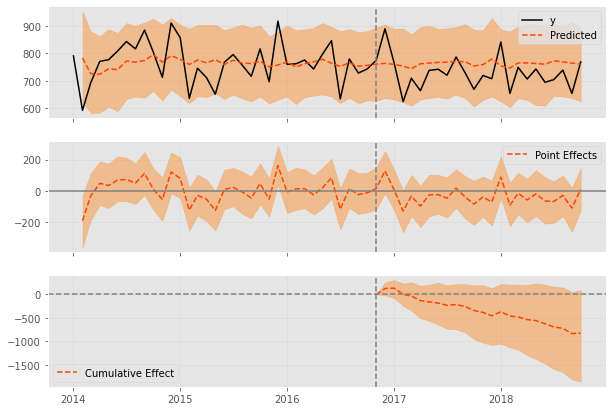

None
Summary results for model ['charges_f', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    75.26              1731.0
Prediction (s.d.)         250.55 (8.95)      5762.72 (205.93)
95% CI                    [232.67, 267.77]   [5351.45, 6158.69]

Absolute effect (s.d.)    -175.29 (8.95)     -4031.72 (205.93)
95% CI                    [-192.51, -157.41] [-4427.69, -3620.45]

Relative effect (s.d.)    -69.96% (3.57%)    -69.96% (3.57%)
95% CI                    [-76.83%, -62.83%] [-76.83%, -62.83%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


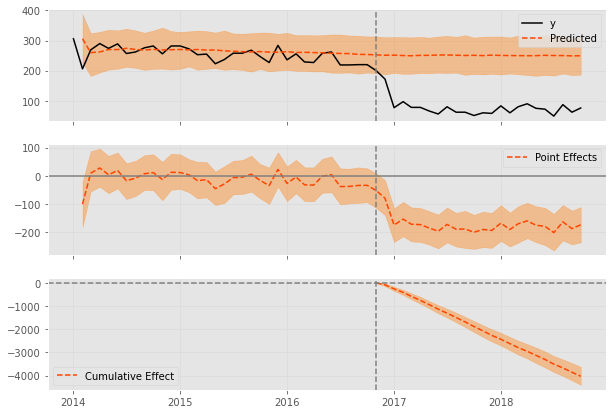

None
Summary results for model ['charges_m', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    651.43             14983.0
Prediction (s.d.)         514.14 (14.68)     11825.12 (337.63)
95% CI                    [486.68, 544.22]   [11193.53, 12517.01]

Absolute effect (s.d.)    137.3 (14.68)      3157.88 (337.63)
95% CI                    [107.22, 164.76]   [2465.99, 3789.47]

Relative effect (s.d.)    26.7% (2.86%)      26.7% (2.86%)
95% CI                    [20.85%, 32.05%]   [20.85%, 32.05%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


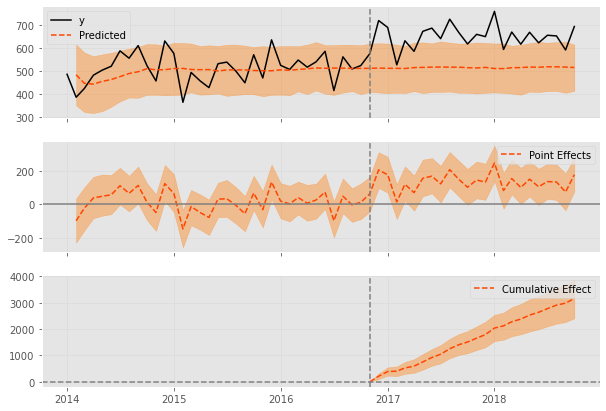

None


In [337]:
multi_all_result, mutli_fel_result, multi_misd_result = [run_causal_impact(dataframe=df.head(-2), cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD_FIX) for col in MULTIVARIATE]